So we know that Gumbel selects things relatively well. Its effects of Zeisel though are a bit muddled because of reconstruction. Let's do a simple synethetic dataset. Half the features are real. Half the features at noise.

In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
#BASE_PATH_DATA = '../data/'
BASE_PATH_DATA = '/scratch/ns3429/sparse-subset/data/'

In [4]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 20
#n_epochs = 20
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999


# from running
# EPSILON = np.finfo(tf.float32.as_numpy_dtype).tiny
#EPSILON = 1.1754944e-38
EPSILON = 1e-10

In [5]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'

In [6]:
print("Device")
print(device)

Device
cuda:0


Create the data

In [7]:
D = 30
N = 5000
z_size = 5

In [8]:
latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

In [9]:
data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

Sequential(
  (0): Linear(in_features=5, out_features=10, bias=False)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=30, bias=True)
  (3): ReLU()
)

In [10]:
latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

tensor([[ 1.7641,  0.4002,  0.9787,  2.2409,  1.8676],
        [-0.9773,  0.9501, -0.1514, -0.1032,  0.4106],
        [ 0.1440,  1.4543,  0.7610,  0.1217,  0.4439],
        ...,
        [ 0.2501, -1.0168,  0.0459,  0.5006,  1.2243],
        [-0.5595,  1.5234, -0.5857,  0.8466, -0.1063],
        [ 0.7700,  0.7508, -0.5606, -1.7603,  0.4371]], device='cuda:0')

In [11]:
actual_data = data_mapper(latent_data)

In [12]:
for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(19, device='cuda:0')
tensor(12, device='cuda:0')
tensor(18, device='cuda:0')
tensor(14, device='cuda:0')
tensor(14, device='cuda:0')


For each sample, half the data is non zero, whereas in zeisel, about 25% if non zero. Easier than Zeisel good.

In [13]:
noise_features = torch.empty(N * D).normal_(mean=0,std=0.01).reshape(N, D).to(device)
noise_features.requires_grad_(False)

tensor([[-1.0921e-02, -6.1085e-04, -1.4928e-02,  ..., -1.4309e-02,
          1.6859e-02, -1.2177e-02],
        [ 7.6496e-03,  1.1971e-02, -2.2414e-02,  ...,  1.0256e-02,
         -5.5957e-03,  4.3434e-03],
        [ 2.7566e-03,  1.0969e-03,  3.5942e-03,  ...,  6.0039e-03,
          8.7524e-04,  7.0365e-03],
        ...,
        [ 1.8449e-02,  8.3797e-04, -8.9499e-03,  ...,  8.9735e-04,
         -1.6982e-03,  7.8153e-03],
        [-1.0649e-02, -9.6204e-03, -8.1562e-03,  ..., -2.2612e-04,
         -1.4104e-02, -8.2127e-03],
        [ 2.1183e-02, -1.1416e-02,  1.8769e-03,  ..., -1.3100e-02,
         -6.2333e-03, -4.3646e-05]], device='cuda:0')

In [14]:
actual_data = torch.cat([actual_data, noise_features], dim = 1)

In [15]:
actual_data.shape

torch.Size([5000, 60])

In [16]:
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

In [17]:
actual_data.std(dim = 0)

tensor([0.1866, 0.2313, 0.2054, 0.2209, 0.2323, 0.1899, 0.1801, 0.1969, 0.1133,
        0.2353, 0.0925, 0.1310, 0.1725, 0.1902, 0.2294, 0.2275, 0.2082, 0.0530,
        0.0980, 0.1738, 0.1728, 0.2156, 0.0460, 0.0932, 0.0255, 0.1816, 0.1587,
        0.2263, 0.2125, 0.2393, 0.1326, 0.1439, 0.1281, 0.1421, 0.1297, 0.1413,
        0.1492, 0.1272, 0.1233, 0.1420, 0.1422, 0.1363, 0.1256, 0.1288, 0.1377,
        0.1438, 0.1337, 0.1331, 0.1258, 0.1346, 0.1507, 0.1223, 0.1429, 0.1343,
        0.1348, 0.1361, 0.1388, 0.1391, 0.1426, 0.1383], device='cuda:0')

Standard deviatiosn are comparable.

In [18]:
actual_data.max(dim = 0)

torch.return_types.max(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0'),
indices=tensor([ 738, 4262, 1553, 1484, 2220, 1316, 3892, 1316, 3121, 3883, 1838,  623,
        1004, 4856,  689, 2033, 2038, 1316, 4515, 4562, 4668,  616,  894, 4515,
        1885, 3892, 4615,  819, 4397, 4293,  713, 2220, 3813, 4659, 4389, 3659,
         309, 1804,  495, 4790, 3110, 4671,   36,    0, 1215,  148, 4008, 1317,
        2503, 1402, 1580, 2684, 4078, 3334, 1376, 2499, 1301, 3114, 4203, 3183],
     

In [19]:
actual_data.min(dim = 0)

torch.return_types.min(
values=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'),
indices=tensor([   1,    8,    0,    1,    0,    5,    1,    1,    1,    0,    1,    1,
           0,   13,    3,    3,    1,    0,    0,    1,    1,    8,    0,    0,
           0,    1,  254,    4,    0,    0,  454, 3677, 1909, 3750, 3638, 4476,
         553, 4105,  289, 1150, 2707, 1846, 3579, 3101,  299, 1324, 3277, 4318,
        3023,  967, 2932, 3588,  919, 1190,  271, 2937, 3428, 3955, 2719,  198],
       device='cuda:0'))

In [20]:
for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(49, device='cuda:0')
tensor(42, device='cuda:0')
tensor(48, device='cuda:0')
tensor(44, device='cuda:0')
tensor(44, device='cuda:0')


In [21]:
slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

In [22]:
train_data.shape

torch.Size([4000, 60])

In [23]:
test_data.shape

torch.Size([1000, 60])

Look at correlations

In [24]:
def pairwise_correlations(dataset):
    cor_df = np.zeros((dataset.shape[1], dataset.shape[1]))
    for row in np.arange(dataset.shape[1]):
        for col in np.arange(dataset.shape[1]):
            cor_df[row, col] = pearsonr(dataset[row], dataset[col])[0]
    return cor_df

16
2


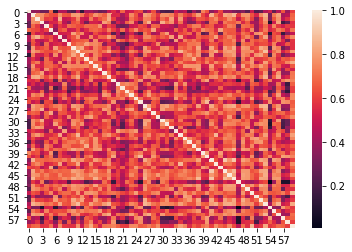

In [25]:
actual_data_clone = actual_data.clone().detach().cpu().numpy()

pairwise_cor_df = pairwise_correlations(actual_data_clone)

import seaborn as sns

sns.heatmap(pairwise_cor_df)

correlates = []
for i in range(2 * D):
    one = np.sum(np.abs(pairwise_cor_df[i, :D]))
    two = np.sum(np.abs(pairwise_cor_df[i, D:2*D]))
    #correlates.append([one, two])
    correlates.append(one > two)
    
# correlation of that feature with the first 30 features and the second 30 features
print(np.sum(correlates[:D]))

print(np.sum(correlates[D:2*D]))

# Now run all of the notebook or just the last part focusing on gumbel vs gradients on truncated (or not) losses

Data is all ready. Now time to feed into into a pretraining-matching Gumbel and joint training Gumbel.

Pre train VAE First

In [26]:
pretrain_vae = VAE(2*D, 100, 20)

pretrain_vae.to(device)
pretrain_vae_optimizer = torch.optim.Adam(pretrain_vae.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

#pretrain_vae_optimizer = torch.optim.SGD(pretrain_vae.parameters(), 
#                                            lr=lr, momentum = 0.9)

In [27]:
for epoch in range(1, n_epochs + 1):
    train(train_data, pretrain_vae, pretrain_vae_optimizer, epoch, batch_size)
    test(test_data, pretrain_vae, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 42.040878
Train Epoch: 1 [1280/4000 (32%)]	Loss: 41.438320
Train Epoch: 1 [2560/4000 (64%)]	Loss: 40.925156
Train Epoch: 1 [3840/4000 (96%)]	Loss: 40.317234
====> Epoch: 1 Average loss: 41.1614
====> Test set loss: 40.2349
Train Epoch: 2 [0/4000 (0%)]	Loss: 40.268456
Train Epoch: 2 [1280/4000 (32%)]	Loss: 39.820087
Train Epoch: 2 [2560/4000 (64%)]	Loss: 39.064011
Train Epoch: 2 [3840/4000 (96%)]	Loss: 38.332138
====> Epoch: 2 Average loss: 39.3663
====> Test set loss: 38.3062
Train Epoch: 3 [0/4000 (0%)]	Loss: 38.370636
Train Epoch: 3 [1280/4000 (32%)]	Loss: 37.520363
Train Epoch: 3 [2560/4000 (64%)]	Loss: 36.419781
Train Epoch: 3 [3840/4000 (96%)]	Loss: 36.041069
====> Epoch: 3 Average loss: 36.9965
====> Test set loss: 35.6713
Train Epoch: 4 [0/4000 (0%)]	Loss: 35.697887
Train Epoch: 4 [1280/4000 (32%)]	Loss: 35.314838
Train Epoch: 4 [2560/4000 (64%)]	Loss: 34.737511
Train Epoch: 4 [3840/4000 (96%)]	Loss: 34.284576
====> Epoch: 4 Average loss: 35.04

In [28]:
with torch.no_grad():
    print("Test Loss")
    print(F.binary_cross_entropy(pretrain_vae(test_data)[0], test_data))

Test Loss
tensor(0.5149, device='cuda:0')


Actually pretty good! %35 percent off when wrong

Get 0.49 when nepochs is 50.
Get 0.54 when nepochs is 10.

As a note, if the final layer of the data mapper is not ReLU, this reconstruction is usually on point. When some of the features can be sparse, then this becomes troublesome.

Compare means

In [29]:
train_data.mean(dim = 0)[:D]

tensor([0.0931, 0.3051, 0.1384, 0.2096, 0.2092, 0.2112, 0.1042, 0.2325, 0.0347,
        0.2014, 0.0244, 0.0502, 0.0919, 0.2735, 0.2254, 0.3294, 0.2786, 0.0084,
        0.0338, 0.1001, 0.0849, 0.2512, 0.0048, 0.0257, 0.0015, 0.0874, 0.4764,
        0.3270, 0.2107, 0.2899], device='cuda:0')

In [30]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [31]:
pretrain_vae(test_data)[0].mean(dim = 0)[:D]

tensor([0.1002, 0.3100, 0.1476, 0.2128, 0.2175, 0.2078, 0.1165, 0.2329, 0.0379,
        0.2061, 0.0331, 0.0601, 0.0990, 0.2806, 0.2365, 0.3387, 0.2734, 0.0217,
        0.0397, 0.0952, 0.1013, 0.2564, 0.0201, 0.0326, 0.0182, 0.1010, 0.4756,
        0.3285, 0.2208, 0.2978], device='cuda:0', grad_fn=<SliceBackward>)

Compare standard deviations

In [32]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [33]:
pretrain_vae(test_data)[0].std(dim = 0)[:D]

tensor([0.0867, 0.1243, 0.1361, 0.1189, 0.1213, 0.0693, 0.1257, 0.1406, 0.0439,
        0.1372, 0.0388, 0.0622, 0.0814, 0.1616, 0.2062, 0.2019, 0.0923, 0.0244,
        0.0393, 0.0729, 0.1034, 0.1457, 0.0285, 0.0343, 0.0240, 0.1338, 0.0751,
        0.1946, 0.0811, 0.1522], device='cuda:0', grad_fn=<SliceBackward>)

In [34]:
pretrain_vae(test_data)[0].std(dim = 0)[D:2*D]

tensor([0.0203, 0.0233, 0.0177, 0.0187, 0.0195, 0.0208, 0.0190, 0.0217, 0.0194,
        0.0207, 0.0201, 0.0231, 0.0224, 0.0179, 0.0207, 0.0183, 0.0188, 0.0193,
        0.0163, 0.0222, 0.0184, 0.0201, 0.0237, 0.0217, 0.0185, 0.0215, 0.0213,
        0.0240, 0.0228, 0.0213], device='cuda:0', grad_fn=<SliceBackward>)

In [35]:
average_std = pretrain_vae(test_data)[0].std(dim = 0)[:D] / test_data.std(dim = 0)[:D]

In [36]:
print(average_std)
print(average_std.mean().item())

tensor([0.4556, 0.5455, 0.6610, 0.5579, 0.5544, 0.3877, 0.6828, 0.7254, 0.4056,
        0.6084, 0.4012, 0.4387, 0.5227, 0.8498, 0.8759, 0.8662, 0.4676, 0.6447,
        0.4209, 0.4263, 0.5817, 0.6613, 0.5605, 0.3631, 1.5810, 0.7067, 0.4824,
        0.8679, 0.4042, 0.6486], device='cuda:0', grad_fn=<DivBackward0>)
0.6118571162223816


Get .8 as the mean when nepoch is 50. Get 0.43 as the mean when nepochs is 10.

Compare values

In [37]:
samp = 45

In [38]:
test_data[samp,:D]

tensor([0.0000, 0.5286, 0.0000, 0.0231, 0.6963, 0.3966, 0.0103, 0.2939, 0.0000,
        0.3152, 0.0000, 0.0000, 0.0000, 0.0617, 0.4150, 0.6262, 0.2110, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6829, 0.0000, 0.0000, 0.0000, 0.0000, 0.3516,
        0.0000, 0.6491, 0.4560], device='cuda:0')

In [39]:
pretrain_vae(test_data)[0][samp, :D]

tensor([0.0299, 0.2970, 0.0424, 0.2183, 0.3280, 0.2362, 0.0718, 0.2682, 0.0160,
        0.1803, 0.0128, 0.0275, 0.0890, 0.1758, 0.2215, 0.4475, 0.3044, 0.0163,
        0.0146, 0.0327, 0.0654, 0.3431, 0.0064, 0.0179, 0.0116, 0.0558, 0.4317,
        0.1594, 0.3265, 0.3046], device='cuda:0', grad_fn=<SliceBackward>)

In [40]:
torch.abs(test_data[samp,:D] - pretrain_vae(test_data)[0][samp, :D]).mean()

tensor(0.1185, device='cuda:0', grad_fn=<MeanBackward0>)

In [41]:
pretrain_vae(test_data)[1][:, :D].mean()

tensor(0.1146, device='cuda:0', grad_fn=<MeanBackward0>)

In [42]:
torch.exp(pretrain_vae(test_data)[2][:, :D]).mean()

tensor(0.6333, device='cuda:0', grad_fn=<MeanBackward0>)

In [43]:
pretrain_vae.requires_grad_(False)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=60, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=100, out_features=20, bias=True)
  (enc_logvar): Linear(in_features=100, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=60, bias=True)
    (3): Sigmoid()
  )
)

This looks pretty good.

**Gumbel matching pretrained VAE next**

In [44]:
# let's see how it does here
vae_gumbel_with_pre = VAE_Gumbel(2*D, 100, 20, k = 3*z_size)
vae_gumbel_with_pre.to(device)
vae_gumbel_with_pre_optimizer = torch.optim.Adam(vae_gumbel_with_pre.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [45]:
for epoch in range(1, n_epochs + 1):
    train_pre_trained(train_data, vae_gumbel_with_pre, vae_gumbel_with_pre_optimizer, 
                      epoch, pretrain_vae, batch_size)
    test(test_data, vae_gumbel_with_pre, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 168.219208
Train Epoch: 1 [1280/4000 (32%)]	Loss: 155.237366
Train Epoch: 1 [2560/4000 (64%)]	Loss: 161.268143
Train Epoch: 1 [3840/4000 (96%)]	Loss: 151.776031
====> Epoch: 1 Average loss: 159.1431
====> Test set loss: 40.1893
Train Epoch: 2 [0/4000 (0%)]	Loss: 152.251297
Train Epoch: 2 [1280/4000 (32%)]	Loss: 144.919861
Train Epoch: 2 [2560/4000 (64%)]	Loss: 142.172165
Train Epoch: 2 [3840/4000 (96%)]	Loss: 141.516525
====> Epoch: 2 Average loss: 146.5750
====> Test set loss: 38.8166
Train Epoch: 3 [0/4000 (0%)]	Loss: 136.122559
Train Epoch: 3 [1280/4000 (32%)]	Loss: 134.785812
Train Epoch: 3 [2560/4000 (64%)]	Loss: 128.904449
Train Epoch: 3 [3840/4000 (96%)]	Loss: 128.727493
====> Epoch: 3 Average loss: 132.7747
====> Test set loss: 37.5193
Train Epoch: 4 [0/4000 (0%)]	Loss: 126.363541
Train Epoch: 4 [1280/4000 (32%)]	Loss: 121.623680
Train Epoch: 4 [2560/4000 (64%)]	Loss: 123.583015
Train Epoch: 4 [3840/4000 (96%)]	Loss: 113.317459
====> Epoch: 4 

In [46]:
with torch.no_grad():
    print("Test Loss")
    print(F.binary_cross_entropy(vae_gumbel_with_pre(test_data)[0], test_data))

Test Loss
tensor(0.5389, device='cuda:0')


Means

In [47]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [48]:
vae_gumbel_with_pre(test_data)[0].mean(dim = 0)[:D]

tensor([0.1024, 0.3140, 0.1501, 0.2163, 0.2175, 0.2214, 0.1102, 0.2434, 0.0483,
        0.2128, 0.0389, 0.0598, 0.1022, 0.2799, 0.2342, 0.3367, 0.2845, 0.0300,
        0.0439, 0.1068, 0.0917, 0.2642, 0.0256, 0.0395, 0.0286, 0.0950, 0.4727,
        0.3332, 0.2241, 0.2972], device='cuda:0', grad_fn=<SliceBackward>)

Deviations

In [49]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [50]:
vae_gumbel_with_pre(test_data)[0].std(dim = 0)[:D]

tensor([0.0489, 0.0382, 0.0722, 0.0661, 0.0476, 0.0494, 0.0542, 0.0756, 0.0369,
        0.0635, 0.0307, 0.0383, 0.0466, 0.0789, 0.0941, 0.1072, 0.0429, 0.0276,
        0.0320, 0.0490, 0.0490, 0.0699, 0.0238, 0.0289, 0.0273, 0.0518, 0.0419,
        0.0966, 0.0474, 0.0831], device='cuda:0', grad_fn=<SliceBackward>)

Values

In [51]:
test_data[samp,:D]

tensor([0.0000, 0.5286, 0.0000, 0.0231, 0.6963, 0.3966, 0.0103, 0.2939, 0.0000,
        0.3152, 0.0000, 0.0000, 0.0000, 0.0617, 0.4150, 0.6262, 0.2110, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6829, 0.0000, 0.0000, 0.0000, 0.0000, 0.3516,
        0.0000, 0.6491, 0.4560], device='cuda:0')

In [52]:
vae_gumbel_with_pre(test_data)[0][samp, :D]

tensor([0.1260, 0.3472, 0.1572, 0.3154, 0.2828, 0.2629, 0.1789, 0.3836, 0.0970,
        0.1962, 0.0766, 0.1059, 0.1447, 0.2776, 0.4030, 0.4705, 0.3816, 0.0574,
        0.0718, 0.1282, 0.2241, 0.3744, 0.0557, 0.0664, 0.0492, 0.1468, 0.5124,
        0.2305, 0.2370, 0.2446], device='cuda:0', grad_fn=<SliceBackward>)

In [53]:
with torch.no_grad():
    w = vae_gumbel_with_pre.weight_creator(test_data[0:2, :])
    subset_indices = sample_subset(w, k=3*z_size, t=0.1).cpu()

In [54]:
# as long as feature index is lesss than 30, then it isn't picking noise
torch.argsort(subset_indices, dim = 1, descending = True)[:, :3 * z_size]

tensor([[28, 12,  8, 13, 45, 59, 21, 18, 52, 50, 42, 46,  1, 47, 39],
        [35, 55, 34, 38, 50, 11, 30, 17, 26, 41, 33,  3, 40,  4, 19]])

**Joint Train**

In [55]:
joint_vanilla_vae = VAE(2*D, 100, 20)
joint_vanilla_vae.to(device)

joint_vae_gumbel = VAE_Gumbel(2*D, 100, 20, k = 3*z_size)
joint_vae_gumbel.to(device)

joint_optimizer = torch.optim.Adam(list(joint_vanilla_vae.parameters()) + list(joint_vae_gumbel.parameters()), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [56]:
for epoch in range(1, n_epochs + 1):
    train_joint(train_data, joint_vanilla_vae, joint_vae_gumbel, joint_optimizer, epoch, batch_size)
    test_joint(test_data, joint_vanilla_vae, joint_vae_gumbel, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 86.848480
Train Epoch: 1 [1280/4000 (32%)]	Loss: 84.275276
Train Epoch: 1 [2560/4000 (64%)]	Loss: 82.845856
Train Epoch: 1 [3840/4000 (96%)]	Loss: 81.747147
====> Epoch: 1 Average loss: 83.7655
====> Test set loss: 106.0535
Train Epoch: 2 [0/4000 (0%)]	Loss: 81.726105
Train Epoch: 2 [1280/4000 (32%)]	Loss: 80.686974
Train Epoch: 2 [2560/4000 (64%)]	Loss: 79.847923
Train Epoch: 2 [3840/4000 (96%)]	Loss: 78.858322
====> Epoch: 2 Average loss: 80.2634
====> Test set loss: 96.4168
Train Epoch: 3 [0/4000 (0%)]	Loss: 78.898964
Train Epoch: 3 [1280/4000 (32%)]	Loss: 77.950134
Train Epoch: 3 [2560/4000 (64%)]	Loss: 77.212387
Train Epoch: 3 [3840/4000 (96%)]	Loss: 76.307381
====> Epoch: 3 Average loss: 77.5121
====> Test set loss: 90.1183
Train Epoch: 4 [0/4000 (0%)]	Loss: 76.061302
Train Epoch: 4 [1280/4000 (32%)]	Loss: 75.339722
Train Epoch: 4 [2560/4000 (64%)]	Loss: 74.579987
Train Epoch: 4 [3840/4000 (96%)]	Loss: 73.783607
====> Epoch: 4 Average loss: 74.9

In [57]:
with torch.no_grad():
    print("Test Loss")
    print(F.binary_cross_entropy(joint_vae_gumbel(test_data)[0], test_data))

Test Loss
tensor(0.5452, device='cuda:0')


Means

In [58]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [59]:
joint_vae_gumbel(test_data)[0].mean(dim = 0)[:D]

tensor([0.1078, 0.3124, 0.1577, 0.2222, 0.2225, 0.2211, 0.1145, 0.2420, 0.0653,
        0.2137, 0.0455, 0.0678, 0.1044, 0.2837, 0.2368, 0.3319, 0.2860, 0.0432,
        0.0580, 0.1193, 0.0988, 0.2575, 0.0338, 0.0576, 0.0425, 0.1012, 0.4774,
        0.3368, 0.2207, 0.2978], device='cuda:0', grad_fn=<SliceBackward>)

Deviations

In [60]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [61]:
joint_vae_gumbel(test_data)[0].std(dim = 0)[:D]

tensor([0.0452, 0.0416, 0.0576, 0.0502, 0.0535, 0.0399, 0.0450, 0.0479, 0.0390,
        0.0504, 0.0335, 0.0421, 0.0419, 0.0363, 0.0495, 0.0332, 0.0363, 0.0307,
        0.0351, 0.0520, 0.0463, 0.0400, 0.0276, 0.0389, 0.0311, 0.0454, 0.0236,
        0.0383, 0.0481, 0.0447], device='cuda:0', grad_fn=<SliceBackward>)

Values

In [62]:
test_data[samp,:D]

tensor([0.0000, 0.5286, 0.0000, 0.0231, 0.6963, 0.3966, 0.0103, 0.2939, 0.0000,
        0.3152, 0.0000, 0.0000, 0.0000, 0.0617, 0.4150, 0.6262, 0.2110, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6829, 0.0000, 0.0000, 0.0000, 0.0000, 0.3516,
        0.0000, 0.6491, 0.4560], device='cuda:0')

In [63]:
joint_vae_gumbel(test_data)[0][samp, :D]

tensor([0.0701, 0.2890, 0.1689, 0.1704, 0.1435, 0.1886, 0.0755, 0.2708, 0.0325,
        0.1740, 0.0354, 0.0469, 0.0618, 0.2541, 0.2209, 0.3065, 0.2965, 0.0297,
        0.0269, 0.0873, 0.0863, 0.1973, 0.0103, 0.0357, 0.0260, 0.0666, 0.4750,
        0.3386, 0.1913, 0.2646], device='cuda:0', grad_fn=<SliceBackward>)

In [64]:
with torch.no_grad():
    w = joint_vae_gumbel.weight_creator(test_data[0:2, :])
    subset_indices = sample_subset(w, k=3*z_size, t=0.1).cpu()

In [65]:
torch.argsort(subset_indices, dim = 1, descending = True)[:, :3 * z_size]

tensor([[ 6, 45,  5, 47, 46,  7, 26, 19, 16, 42,  8, 31, 50, 36,  4],
        [45, 28, 15, 31,  3, 18, 27, 35, 48, 19, 52,  0, 43,  9, 20]])

Joint Training while selecting exactly z_size. Why does it pick the noise variables?

In [66]:
joint_vanilla_vae = VAE(2*D, 100, 20)
joint_vanilla_vae.to(device)

joint_vae_gumbel = VAE_Gumbel(2*D, 100, 20, k = z_size)
joint_vae_gumbel.to(device)

joint_optimizer = torch.optim.Adam(list(joint_vanilla_vae.parameters()) + list(joint_vae_gumbel.parameters()), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [67]:
for epoch in range(1, n_epochs + 1):
    train_joint(train_data, joint_vanilla_vae, joint_vae_gumbel, joint_optimizer, epoch, batch_size)
    test_joint(test_data, joint_vanilla_vae, joint_vae_gumbel, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 85.054405
Train Epoch: 1 [1280/4000 (32%)]	Loss: 83.330345
Train Epoch: 1 [2560/4000 (64%)]	Loss: 82.286453
Train Epoch: 1 [3840/4000 (96%)]	Loss: 81.242546
====> Epoch: 1 Average loss: 82.9093
====> Test set loss: 97.6358
Train Epoch: 2 [0/4000 (0%)]	Loss: 81.174263
Train Epoch: 2 [1280/4000 (32%)]	Loss: 80.213066
Train Epoch: 2 [2560/4000 (64%)]	Loss: 79.237938
Train Epoch: 2 [3840/4000 (96%)]	Loss: 78.435249
====> Epoch: 2 Average loss: 79.7377
====> Test set loss: 90.1511
Train Epoch: 3 [0/4000 (0%)]	Loss: 78.242432
Train Epoch: 3 [1280/4000 (32%)]	Loss: 77.535652
Train Epoch: 3 [2560/4000 (64%)]	Loss: 76.462410
Train Epoch: 3 [3840/4000 (96%)]	Loss: 75.758675
====> Epoch: 3 Average loss: 76.9780
====> Test set loss: 84.4369
Train Epoch: 4 [0/4000 (0%)]	Loss: 75.658134
Train Epoch: 4 [1280/4000 (32%)]	Loss: 74.409744
Train Epoch: 4 [2560/4000 (64%)]	Loss: 73.804512
Train Epoch: 4 [3840/4000 (96%)]	Loss: 73.436516
====> Epoch: 4 Average loss: 74.36

In [68]:
with torch.no_grad():
    print("Test Loss")
    print(F.binary_cross_entropy(joint_vae_gumbel(test_data)[0], test_data))

Test Loss
tensor(0.5454, device='cuda:0')


Means

In [69]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [70]:
joint_vae_gumbel(test_data)[0].mean(dim = 0)[:D]

tensor([0.1080, 0.3095, 0.1499, 0.2192, 0.2195, 0.2185, 0.1156, 0.2413, 0.0600,
        0.2146, 0.0606, 0.0694, 0.1076, 0.2810, 0.2337, 0.3362, 0.2855, 0.0416,
        0.0580, 0.1115, 0.1001, 0.2579, 0.0355, 0.0471, 0.0343, 0.0980, 0.4774,
        0.3319, 0.2198, 0.2976], device='cuda:0', grad_fn=<SliceBackward>)

Deviations

In [71]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [72]:
joint_vae_gumbel(test_data)[0].std(dim = 0)[:D]

tensor([0.0488, 0.0359, 0.0530, 0.0466, 0.0421, 0.0457, 0.0490, 0.0465, 0.0417,
        0.0520, 0.0442, 0.0401, 0.0541, 0.0396, 0.0469, 0.0393, 0.0390, 0.0336,
        0.0387, 0.0432, 0.0507, 0.0386, 0.0343, 0.0347, 0.0326, 0.0458, 0.0243,
        0.0362, 0.0481, 0.0422], device='cuda:0', grad_fn=<SliceBackward>)

Values

In [73]:
test_data[samp,:D]

tensor([0.0000, 0.5286, 0.0000, 0.0231, 0.6963, 0.3966, 0.0103, 0.2939, 0.0000,
        0.3152, 0.0000, 0.0000, 0.0000, 0.0617, 0.4150, 0.6262, 0.2110, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6829, 0.0000, 0.0000, 0.0000, 0.0000, 0.3516,
        0.0000, 0.6491, 0.4560], device='cuda:0')

In [74]:
joint_vae_gumbel(test_data)[0][samp, :D]

tensor([0.0940, 0.3125, 0.1479, 0.2326, 0.2295, 0.2024, 0.0806, 0.2793, 0.0788,
        0.2053, 0.0612, 0.0664, 0.0838, 0.2944, 0.2076, 0.3659, 0.2146, 0.0408,
        0.0572, 0.0857, 0.1275, 0.2184, 0.0294, 0.0566, 0.0222, 0.0799, 0.4787,
        0.3291, 0.2355, 0.2589], device='cuda:0', grad_fn=<SliceBackward>)

In [75]:
with torch.no_grad():
    w = joint_vae_gumbel.weight_creator(test_data[0:10, :])
    subset_indices = sample_subset(w, k=z_size, t=0.1).cpu()

In [76]:
torch.argsort(subset_indices, dim = 1, descending = True)[:, :z_size]

tensor([[36, 14, 37, 55, 25],
        [15, 26,  2, 54, 55],
        [46, 37, 44, 13, 15],
        [23, 11, 40, 34, 31],
        [53,  6, 49, 21, 20],
        [38,  8, 29, 48, 28],
        [17, 38, 31,  6, 25],
        [ 4, 59, 50, 39, 37],
        [ 4, 58, 29, 30, 32],
        [17, 16,  4,  9,  7]])

Matching pre trained is actually better here than joint training.
The gumbel trick greatly reduces the ability to make predictions. 
Notice that the standard deviations are not as high as in the original data. Not being able to use a model looking at the full data as an anchor definitely hurts.

# Calculation of Loss only over select features
What happens if we limit the calculation of the loss to just the first few non-noisy stuff?

Not doing joint training here because the calculation of loss is hidden inside utils and cannot modify the indexing so easily.

In [77]:
def train_truncated_with_gradients(df, model, optimizer, epoch, batch_size, Dim):
    model.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    gradients = torch.zeros(df.shape[1]).to(device)
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :].clone().to(device)
        
        
        # need to do this twice because deriative with respect to input not implemented in BCE
        # so need to switch them up
        optimizer.zero_grad()
        batch_data.requires_grad_(True)
        mu_x, mu_latent, logvar_latent = model(batch_data)
        # why clone detach here?
        # still want gradient with respect to input, but BCE gradient with respect to target is not defined
        # plus we only want to see how input affects mu_x, not the target
        loss = loss_function_per_autoencoder(batch_data[:, :Dim].clone().detach(), mu_x[:, :Dim], 
                                             mu_latent, logvar_latent) 
        loss.backward(retain_graph=True)

        with torch.no_grad():
            gradients += torch.sqrt(batch_data.grad ** 2).sum(dim = 0)
        # no step
        
        optimizer.zero_grad()
        # do not calculate with respect to 
        batch_data.requires_grad_(False)
        mu_x.requires_grad_(True)
        loss = loss_function_per_autoencoder(batch_data[:, :Dim], mu_x[:, :Dim], mu_latent, logvar_latent) 
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data)/ len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))
    
    return gradients
    
# match pre trained model
def train_pre_trained_truncated(df, model, optimizer, epoch, pretrained_model, batch_size, D):
    model.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :].clone()
        
        batch_data.requires_grad_(True)
        
        optimizer.zero_grad()
        mu_x, mu_latent, logvar_latent = model(batch_data)
        with torch.no_grad():
            _, mu_latent_2, logvar_latent_2 = pretrained_model(batch_data)
        
        loss = loss_function_per_autoencoder(batch_data[:, :D], mu_x[:, :D], mu_latent, logvar_latent)
        loss += 10*F.mse_loss(mu_latent, mu_latent_2, reduction = 'sum')
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data)/ len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))

In [78]:
global_t = 0.1

In [79]:
# let's see how it does here
vae_gumbel_truncated = VAE_Gumbel(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

Just train a gumbel without matching or joint training to see

In [80]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                         vae_gumbel_trunc_optimizer, epoch, batch_size, Dim = D)
    if epoch > 5:
        gradients += grads
    test(test_data, vae_gumbel_truncated, epoch, batch_size)
    
gradients = gradients

Train Epoch: 1 [0/4000 (0%)]	Loss: 21.093872
Train Epoch: 1 [1280/4000 (32%)]	Loss: 20.668814
Train Epoch: 1 [2560/4000 (64%)]	Loss: 20.204716
Train Epoch: 1 [3840/4000 (96%)]	Loss: 19.703491
====> Epoch: 1 Average loss: 20.3773
====> Test set loss: 40.6477
Train Epoch: 2 [0/4000 (0%)]	Loss: 19.545073
Train Epoch: 2 [1280/4000 (32%)]	Loss: 18.960094
Train Epoch: 2 [2560/4000 (64%)]	Loss: 18.473204
Train Epoch: 2 [3840/4000 (96%)]	Loss: 17.832443
====> Epoch: 2 Average loss: 18.8130
====> Test set loss: 39.1452
Train Epoch: 3 [0/4000 (0%)]	Loss: 18.011776
Train Epoch: 3 [1280/4000 (32%)]	Loss: 17.209455
Train Epoch: 3 [2560/4000 (64%)]	Loss: 16.648760
Train Epoch: 3 [3840/4000 (96%)]	Loss: 16.204090
====> Epoch: 3 Average loss: 17.0178
====> Test set loss: 37.2402
Train Epoch: 4 [0/4000 (0%)]	Loss: 15.912292
Train Epoch: 4 [1280/4000 (32%)]	Loss: 15.318943
Train Epoch: 4 [2560/4000 (64%)]	Loss: 14.522866
Train Epoch: 4 [3840/4000 (96%)]	Loss: 14.258093
====> Epoch: 4 Average loss: 14.87

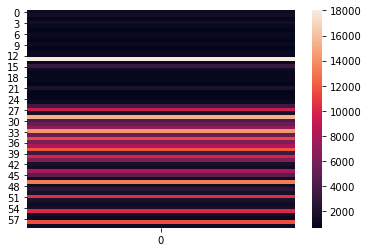

In [81]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [82]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [83]:
vae_gumbel_truncated(test_data)[0].mean(dim = 0)[:D]

tensor([0.1148, 0.3103, 0.1607, 0.2130, 0.2203, 0.2164, 0.1107, 0.2323, 0.0488,
        0.2214, 0.0400, 0.0656, 0.1128, 0.2947, 0.2303, 0.3229, 0.2823, 0.0309,
        0.0529, 0.1148, 0.0933, 0.2548, 0.0326, 0.0445, 0.0233, 0.0937, 0.4761,
        0.3437, 0.2285, 0.3099], device='cuda:0', grad_fn=<SliceBackward>)

In [84]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [85]:
vae_gumbel_truncated(test_data)[0].std(dim = 0)[:D]

tensor([0.0556, 0.0347, 0.0505, 0.0569, 0.0638, 0.0486, 0.0499, 0.0591, 0.0438,
        0.0514, 0.0384, 0.0493, 0.0548, 0.0377, 0.0710, 0.0368, 0.0384, 0.0319,
        0.0425, 0.0477, 0.0551, 0.0525, 0.0342, 0.0383, 0.0272, 0.0547, 0.0251,
        0.0359, 0.0535, 0.0358], device='cuda:0', grad_fn=<SliceBackward>)

In [86]:
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices = sample_subset(w, k=3*z_size, t=global_t).cpu()

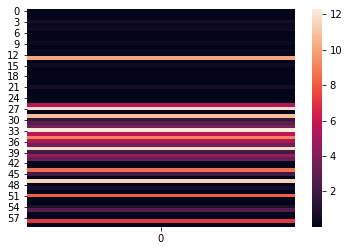

In [87]:
sns.heatmap(subset_indices.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [88]:
subset_indices

tensor([[7.8803e-09, 1.4471e-04, 5.5669e-03, 6.0727e-01, 4.1324e-12, 7.9017e-11,
         2.1042e-10, 2.8982e-07, 5.7122e-11, 6.2353e-12, 8.7536e-06, 1.2823e-11,
         3.1752e-02, 8.8964e-03, 1.2161e-08, 3.3722e-10, 8.6845e-05, 3.6338e-05,
         1.5179e-05, 5.8932e-02, 4.9361e-03, 2.2064e-09, 2.8243e-16, 7.3968e-08,
         2.0032e-09, 1.0720e-07, 2.3200e-08, 1.5558e+00, 3.9544e-02, 1.1767e+00,
         2.7878e-02, 1.1934e+00, 3.5791e-03, 1.3557e+00, 1.0642e+00, 9.5752e-01,
         1.1614e+00, 1.2978e-03, 1.0829e+00, 5.3039e-02, 3.0662e-01, 6.2086e-01,
         6.0323e-09, 1.9525e-03, 2.4324e-25, 5.1195e-01, 5.8341e-06, 9.7766e-01,
         1.7341e-07, 5.5809e-13, 1.3543e-10, 1.6737e+00, 1.6442e-14, 1.6899e-05,
         1.1059e-09, 2.0334e-01, 1.2238e-01, 2.3391e-04, 1.9057e-01, 3.1766e-06],
        [2.5827e-04, 1.8095e-06, 1.4449e-10, 1.6598e-09, 1.3464e-22, 5.2488e-13,
         2.0511e-05, 6.1863e-14, 2.8131e-11, 5.5801e-07, 3.2731e-09, 7.6450e-13,
         1.3932e-21, 9.9730

In [89]:
torch.argsort(subset_indices, dim = 1, descending = True)[:, :3*z_size]

tensor([[51, 27, 33, 31, 29, 36, 38, 34, 47, 35, 41,  3, 45, 40, 55],
        [47, 38, 29, 35, 44, 34, 13, 51, 32, 27, 40, 36, 33, 31, 15],
        [33, 13, 27, 38, 44, 36, 47, 29, 54, 51, 34, 41, 30, 39, 40],
        [47, 44, 33, 35, 38, 37, 40, 31, 27, 29, 26, 21, 58, 13, 41],
        [27, 38, 33, 58, 13, 35, 47, 37, 40, 29, 44, 41, 26, 32, 34],
        [58, 27, 29, 39, 35, 47, 44, 51, 37, 30, 13, 32, 26, 40, 38],
        [26, 58, 13, 38, 33, 27, 55, 29, 51, 36, 40,  5,  4, 45, 21],
        [27, 51, 35, 29, 13, 47, 33, 34, 32, 36, 38, 41, 55,  2, 44],
        [44, 51, 36, 58, 26, 29, 47, 33, 55, 27, 38, 32, 13, 49, 11],
        [33, 34, 41, 47, 13, 29, 35, 45, 26, 44, 40, 38, 39, 37,  9]])

In [90]:
print(subset_indices[:, :D].sum())

print(subset_indices[:, D:2*D].sum())

tensor(42.0417)
tensor(107.9584)


In [91]:
torch.sum(w.argsort(descending= True)[:, :3*z_size] < 30)

tensor(37, device='cuda:0')

What happens if you run it on all the data? And not truncate the loss to the first D features?

In [92]:
# let's see how it does here
vae_gumbel_truncated = VAE_Gumbel(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [93]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                         vae_gumbel_trunc_optimizer, epoch, batch_size, Dim = 2*D)
    if epoch > 5:
        gradients += grads
    test(test_data, vae_gumbel_truncated, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 42.366001
Train Epoch: 1 [1280/4000 (32%)]	Loss: 41.894085
Train Epoch: 1 [2560/4000 (64%)]	Loss: 41.278465
Train Epoch: 1 [3840/4000 (96%)]	Loss: 40.899498
====> Epoch: 1 Average loss: 41.5525
====> Test set loss: 40.7214
Train Epoch: 2 [0/4000 (0%)]	Loss: 40.682613
Train Epoch: 2 [1280/4000 (32%)]	Loss: 40.277554
Train Epoch: 2 [2560/4000 (64%)]	Loss: 39.740192
Train Epoch: 2 [3840/4000 (96%)]	Loss: 39.320194
====> Epoch: 2 Average loss: 39.9941
====> Test set loss: 39.2005
Train Epoch: 3 [0/4000 (0%)]	Loss: 39.060650
Train Epoch: 3 [1280/4000 (32%)]	Loss: 38.825985
Train Epoch: 3 [2560/4000 (64%)]	Loss: 38.163338
Train Epoch: 3 [3840/4000 (96%)]	Loss: 37.594349
====> Epoch: 3 Average loss: 38.3954
====> Test set loss: 37.3983
Train Epoch: 4 [0/4000 (0%)]	Loss: 37.367794
Train Epoch: 4 [1280/4000 (32%)]	Loss: 36.446602
Train Epoch: 4 [2560/4000 (64%)]	Loss: 35.709530
Train Epoch: 4 [3840/4000 (96%)]	Loss: 35.274986
====> Epoch: 4 Average loss: 36.30

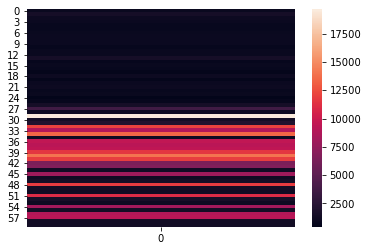

In [94]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [95]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [96]:
vae_gumbel_truncated(test_data)[0].mean(dim = 0)[:D]

tensor([0.1104, 0.3139, 0.1557, 0.2146, 0.2272, 0.2249, 0.1142, 0.2374, 0.0551,
        0.2214, 0.0421, 0.0623, 0.1154, 0.2879, 0.2327, 0.3289, 0.2827, 0.0258,
        0.0542, 0.1214, 0.0979, 0.2593, 0.0293, 0.0478, 0.0303, 0.1002, 0.4750,
        0.3373, 0.2328, 0.3169], device='cuda:0', grad_fn=<SliceBackward>)

In [97]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [98]:
vae_gumbel_truncated(test_data)[0].std(dim = 0)[:D]

tensor([0.0501, 0.0326, 0.0511, 0.0527, 0.0521, 0.0503, 0.0500, 0.0543, 0.0409,
        0.0507, 0.0335, 0.0402, 0.0560, 0.0382, 0.0569, 0.0347, 0.0369, 0.0242,
        0.0387, 0.0613, 0.0464, 0.0418, 0.0283, 0.0363, 0.0296, 0.0466, 0.0253,
        0.0410, 0.0482, 0.0477], device='cuda:0', grad_fn=<SliceBackward>)

In [99]:
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices = sample_subset(w, k=3*z_size, t=global_t).cpu()

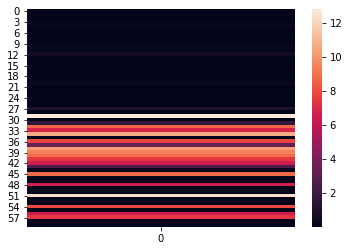

In [100]:
sns.heatmap(subset_indices.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [101]:
subset_indices

tensor([[4.3291e-03, 1.4547e-15, 8.7694e-07, 7.6677e-11, 1.0488e-12, 4.5284e-22,
         3.1184e-21, 5.8956e-14, 6.1925e-08, 1.7970e-09, 6.9047e-11, 4.2175e-04,
         2.8686e-05, 8.6152e-13, 8.6113e-13, 2.2741e-09, 2.4467e-24, 2.5500e-11,
         5.0110e-27, 6.7680e-07, 2.3052e-06, 2.8021e-04, 7.4786e-08, 6.5251e-13,
         3.3192e-13, 1.1250e-06, 1.0398e-25, 3.2190e-01, 2.7976e-08, 1.6642e+00,
         7.0213e-12, 1.4591e-03, 6.1645e-01, 3.0926e-02, 9.8761e-01, 3.0614e-15,
         1.1301e+00, 1.9841e-05, 1.8680e+00, 1.8548e+00, 1.7920e+00, 1.6336e+00,
         6.2688e-03, 2.5296e-06, 2.1825e-09, 7.6417e-01, 2.1222e-17, 2.6941e-18,
         3.5835e-04, 1.0205e-07, 1.4725e-03, 3.5150e-13, 2.5258e-08, 1.1281e-10,
         1.8517e+00, 9.7199e-20, 4.6978e-01, 2.1964e-07, 6.8764e-16, 3.5069e-16],
        [2.8101e-17, 6.1266e-08, 1.5983e-13, 2.0539e-05, 3.0490e-14, 2.7371e-19,
         1.0197e-10, 2.5183e-12, 1.7383e-12, 7.7211e-08, 1.1724e-17, 1.6453e-08,
         3.5100e-18, 1.0168

In [102]:
torch.argsort(subset_indices, dim = 1, descending = True)[:, :3*z_size]

tensor([[38, 39, 54, 40, 29, 41, 36, 34, 45, 32, 56, 27, 33, 42,  0],
        [51, 41, 38, 45, 33, 29, 54, 48, 39, 40, 57, 37, 31, 42, 46],
        [32, 51, 43, 42, 36, 54, 29, 38, 40, 56, 57, 34, 45, 33, 48],
        [29, 51, 39, 48, 38, 32, 57, 54, 34, 36, 27, 56, 43, 33, 31],
        [56, 51, 54, 29, 38, 39, 42, 34, 45, 33, 57, 11, 32, 30, 28],
        [34, 51, 36, 39, 32, 45, 40, 57, 33, 37, 48,  4, 31, 14, 50],
        [51, 48, 42, 33, 41, 32, 39, 56, 34, 29, 40, 37, 12,  4, 57],
        [29, 32, 42, 39, 36, 38, 40, 37, 34, 51, 41, 56, 57, 33, 31],
        [40, 29, 45, 34, 57, 33, 48, 38, 56, 43, 41, 51, 31, 10, 32],
        [45, 36, 37, 32, 41, 42, 57, 54, 48, 34, 29, 38, 31, 46, 56]])

In [103]:
print(subset_indices[:, :D].sum())

print(subset_indices[:, D:2*D].sum())

tensor(15.7327)
tensor(134.2672)


In [104]:
torch.sum(w.argsort(descending= True)[:, :3*z_size] < 30)

tensor(10, device='cuda:0')

# How does a normal VAE do?

Trying to reconstruct first 30 features only

In [105]:
vanilla_vae = VAE(2*D, 100, 20)

vanilla_vae.to(device)
vanilla_vae_optimizer = torch.optim.Adam(vanilla_vae.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

In [106]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vanilla_vae, 
                                         vanilla_vae_optimizer, epoch, batch_size, Dim = D)
    if epoch > 5:
        gradients += grads
    test(test_data, vanilla_vae, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 20.811413
Train Epoch: 1 [1280/4000 (32%)]	Loss: 20.117807
Train Epoch: 1 [2560/4000 (64%)]	Loss: 19.581526
Train Epoch: 1 [3840/4000 (96%)]	Loss: 19.099516
====> Epoch: 1 Average loss: 19.9070
====> Test set loss: 40.0846
Train Epoch: 2 [0/4000 (0%)]	Loss: 19.055134
Train Epoch: 2 [1280/4000 (32%)]	Loss: 18.440933
Train Epoch: 2 [2560/4000 (64%)]	Loss: 17.732121
Train Epoch: 2 [3840/4000 (96%)]	Loss: 17.247393
====> Epoch: 2 Average loss: 18.0550
====> Test set loss: 38.0334
Train Epoch: 3 [0/4000 (0%)]	Loss: 16.820208
Train Epoch: 3 [1280/4000 (32%)]	Loss: 15.795731
Train Epoch: 3 [2560/4000 (64%)]	Loss: 15.425953
Train Epoch: 3 [3840/4000 (96%)]	Loss: 15.025915
====> Epoch: 3 Average loss: 15.5690
====> Test set loss: 36.1794
Train Epoch: 4 [0/4000 (0%)]	Loss: 14.359447
Train Epoch: 4 [1280/4000 (32%)]	Loss: 13.912736
Train Epoch: 4 [2560/4000 (64%)]	Loss: 14.012361
Train Epoch: 4 [3840/4000 (96%)]	Loss: 13.733294
====> Epoch: 4 Average loss: 13.85

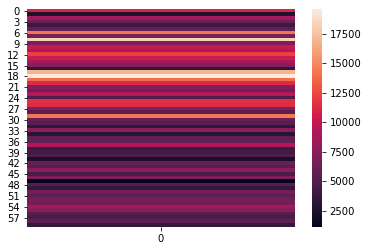

In [107]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [108]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [109]:
vanilla_vae(test_data)[0].mean(dim = 0)[:D]

tensor([0.1036, 0.3097, 0.1537, 0.2227, 0.2226, 0.2176, 0.1148, 0.2424, 0.0421,
        0.2119, 0.0362, 0.0667, 0.1112, 0.2861, 0.2370, 0.3406, 0.2877, 0.0284,
        0.0396, 0.1004, 0.1061, 0.2595, 0.0237, 0.0369, 0.0217, 0.1056, 0.4770,
        0.3284, 0.2258, 0.3023], device='cuda:0', grad_fn=<SliceBackward>)

In [110]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [111]:
vanilla_vae(test_data)[0].std(dim = 0)[:D]

tensor([0.0777, 0.0582, 0.1372, 0.1327, 0.0643, 0.0709, 0.1264, 0.1545, 0.0461,
        0.1284, 0.0444, 0.0733, 0.0907, 0.1657, 0.2094, 0.1932, 0.0638, 0.0405,
        0.0433, 0.0668, 0.1062, 0.1279, 0.0356, 0.0440, 0.0329, 0.1379, 0.0646,
        0.1776, 0.0763, 0.1769], device='cuda:0', grad_fn=<SliceBackward>)

Looking at all dimensions

In [112]:
vanilla_vae = VAE(2*D, 100, 20)

vanilla_vae.to(device)
vanilla_vae_optimizer = torch.optim.Adam(vanilla_vae.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

In [113]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vanilla_vae, 
                                         vanilla_vae_optimizer, epoch, batch_size, Dim = 2*D)
    if epoch > 5:
        gradients += grads
    test(test_data, vanilla_vae, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 42.770042
Train Epoch: 1 [1280/4000 (32%)]	Loss: 42.121311
Train Epoch: 1 [2560/4000 (64%)]	Loss: 41.527489
Train Epoch: 1 [3840/4000 (96%)]	Loss: 41.010853
====> Epoch: 1 Average loss: 41.7969
====> Test set loss: 40.9561
Train Epoch: 2 [0/4000 (0%)]	Loss: 41.069691
Train Epoch: 2 [1280/4000 (32%)]	Loss: 40.465618
Train Epoch: 2 [2560/4000 (64%)]	Loss: 39.950092
Train Epoch: 2 [3840/4000 (96%)]	Loss: 39.169994
====> Epoch: 2 Average loss: 40.1527
====> Test set loss: 39.1702
Train Epoch: 3 [0/4000 (0%)]	Loss: 39.259609
Train Epoch: 3 [1280/4000 (32%)]	Loss: 38.488525
Train Epoch: 3 [2560/4000 (64%)]	Loss: 37.705387
Train Epoch: 3 [3840/4000 (96%)]	Loss: 36.736557
====> Epoch: 3 Average loss: 37.9552
====> Test set loss: 36.4830
Train Epoch: 4 [0/4000 (0%)]	Loss: 36.714951
Train Epoch: 4 [1280/4000 (32%)]	Loss: 35.803600
Train Epoch: 4 [2560/4000 (64%)]	Loss: 35.414822
Train Epoch: 4 [3840/4000 (96%)]	Loss: 35.074821
====> Epoch: 4 Average loss: 35.64

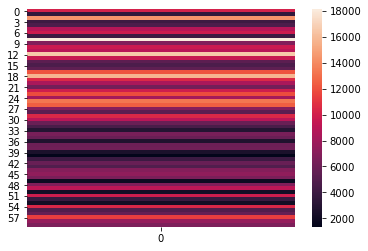

In [114]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [115]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [116]:
vanilla_vae(test_data)[0].mean(dim = 0)[:D]

tensor([0.1024, 0.3083, 0.1548, 0.2167, 0.2263, 0.2134, 0.1191, 0.2376, 0.0462,
        0.2211, 0.0391, 0.0645, 0.1074, 0.2926, 0.2355, 0.3374, 0.2798, 0.0250,
        0.0395, 0.1016, 0.1004, 0.2553, 0.0321, 0.0384, 0.0269, 0.1083, 0.4753,
        0.3296, 0.2227, 0.3098], device='cuda:0', grad_fn=<SliceBackward>)

In [117]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [118]:
vanilla_vae(test_data)[0].std(dim = 0)[:D]

tensor([0.0775, 0.0683, 0.1182, 0.1115, 0.0892, 0.0724, 0.1055, 0.1345, 0.0510,
        0.1129, 0.0451, 0.0560, 0.0805, 0.1525, 0.1804, 0.1922, 0.0643, 0.0321,
        0.0404, 0.0648, 0.0767, 0.1383, 0.0411, 0.0418, 0.0351, 0.1132, 0.0543,
        0.1718, 0.0692, 0.1575], device='cuda:0', grad_fn=<SliceBackward>)

The gradients are a few epochs are good for selecting of features as the Gumbel trick. Maybe even better.
In fact, a Vanilla VAE is just as good.